In [3]:
import asf_search as asf
from shapely.geometry import Point, shape
from rasterio.crs import CRS
import geopandas as gpd
import pandas as pd
import contextily as cx
import matplotlib.pyplot as plt
from pathlib import Path
import requests
from tqdm import tqdm
import concurrent.futures

# Directory

In [4]:
out = Path('out')

# Search

In [10]:

# higland_fire
pt = [-116.4461721, 33.4740632]

## Acpulco
#pt = [-99.8796, 16.8421]

In [23]:
Point(*pt).wkt

'POINT (-116.4461721 33.4740632)'

In [11]:
resp = asf.geo_search(intersectsWith=Point(*pt).wkt,
                      processingLevel='RTC', 
                      platform=asf.constants.SENTINEL1)
len(resp)

16

The number should match this [search](https://search.asf.alaska.edu/#/?polygon=POINT(-99.8796%2016.8421)&zoom=9.133&center=-99.712,16.370&resultsLoaded=true&dataset=OPERA-S1&granule=OPERA_L2_RTC-S1_T078-165486-IW2_20231024T004829Z_20231024T091416Z_S1A_30_v1.0&productTypes=RTC).

In [12]:
properties = [r.properties for r in resp]
geometry = [shape(r.geojson()['geometry']) for r in resp]
properties_f = [{'opera_id': p['sceneName'], 
                 'start_time': p['startTime'],
                 'polarization': p['polarization'],
                 'url': p['url'], 
                 'track_number': p['pathNumber']} for p in properties]

df_resp = gpd.GeoDataFrame(properties_f, geometry=geometry, crs=CRS.from_epsg(4326))
df_resp.head()

,opera_id,start_time,polarization,url,track_number,geometry
0,OPERA_L2_RTC-S1_T173-370320-IW3_20231229T13445...,2023-12-29T13:44:55Z,VV,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,173,"POLYGON ((-116.29247 33.60277, -117.18757 33.7..."
1,OPERA_L2_RTC-S1_T064-135514-IW3_20231222T01503...,2023-12-22T01:50:36Z,VV,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,"POLYGON ((-116.81845 33.41076, -115.95567 33.5..."
2,OPERA_L2_RTC-S1_T173-370320-IW3_20231217T13445...,2023-12-17T13:44:56Z,VV,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,173,"POLYGON ((-116.29228 33.60241, -117.18737 33.7..."
3,OPERA_L2_RTC-S1_T064-135514-IW3_20231210T01503...,2023-12-10T01:50:38Z,VV,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,"POLYGON ((-116.81776 33.41127, -115.95752 33.5..."
4,OPERA_L2_RTC-S1_T064-135514-IW3_20231210T01503...,2023-12-10T01:50:38Z,VV,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,"POLYGON ((-116.81776 33.41127, -115.95752 33.5..."


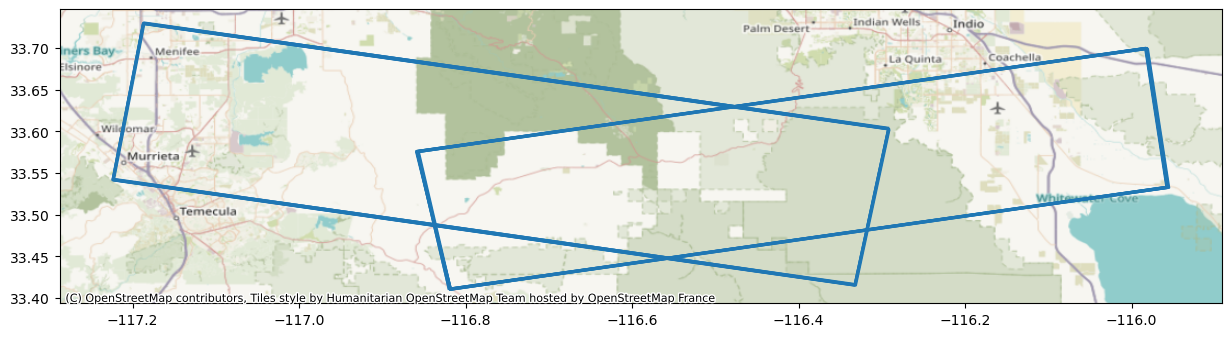

In [22]:
fig, ax = plt.subplots(figsize=(15, 10))
df_resp.exterior.plot(ax=ax)
cx.add_basemap(ax, crs=df_resp.crs.to_string())

## Update dataframe

See this issue: https://github.com/asfadmin/Discovery-asf_search/issues/231

In [14]:
df_resp['polarization'] = 'VH'
df_resp_vv = df_resp.copy()
df_resp_vv['polarization'] = 'VV'
df_resp_vv['url'] = df_resp_vv['url'].map(lambda url: url.replace('VH', 'VV'))
df = pd.concat([df_resp, df_resp_vv], axis=0).reset_index(drop=True)
df.head()

,opera_id,start_time,polarization,url,track_number,geometry
0,OPERA_L2_RTC-S1_T173-370320-IW3_20231229T13445...,2023-12-29T13:44:55Z,VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,173,"POLYGON ((-116.29247 33.60277, -117.18757 33.7..."
1,OPERA_L2_RTC-S1_T064-135514-IW3_20231222T01503...,2023-12-22T01:50:36Z,VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,"POLYGON ((-116.81845 33.41076, -115.95567 33.5..."
2,OPERA_L2_RTC-S1_T173-370320-IW3_20231217T13445...,2023-12-17T13:44:56Z,VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,173,"POLYGON ((-116.29228 33.60241, -117.18737 33.7..."
3,OPERA_L2_RTC-S1_T064-135514-IW3_20231210T01503...,2023-12-10T01:50:38Z,VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,"POLYGON ((-116.81776 33.41127, -115.95752 33.5..."
4,OPERA_L2_RTC-S1_T064-135514-IW3_20231210T01503...,2023-12-10T01:50:38Z,VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,"POLYGON ((-116.81776 33.41127, -115.95752 33.5..."


# Download

In [15]:
tracks = df.track_number.tolist()
opera_ids = df.opera_id.tolist()

out_paths = [out / Path(f'{t}/{oid}') for (t, oid) in zip(tracks, opera_ids)]
out_paths_unique = list(set(out_paths))
out_paths_unique

[PosixPath('out/173/OPERA_L2_RTC-S1_T173-370320-IW3_20231205T134457Z_20231205T203151Z_S1A_30_v1.0'),
 PosixPath('out/64/OPERA_L2_RTC-S1_T064-135514-IW3_20231104T015039Z_20231105T123452Z_S1A_30_v1.0'),
 PosixPath('out/64/OPERA_L2_RTC-S1_T064-135514-IW3_20231011T015039Z_20231011T182934Z_S1A_30_v1.0'),
 PosixPath('out/173/OPERA_L2_RTC-S1_T173-370320-IW3_20231111T134458Z_20231116T013036Z_S1A_30_v1.0'),
 PosixPath('out/64/OPERA_L2_RTC-S1_T064-135514-IW3_20231128T015038Z_20231206T080524Z_S1A_30_v1.0'),
 PosixPath('out/173/OPERA_L2_RTC-S1_T173-370320-IW3_20231123T134457Z_20231206T032347Z_S1A_30_v1.0'),
 PosixPath('out/64/OPERA_L2_RTC-S1_T064-135514-IW3_20231210T015038Z_20231211T141210Z_S1A_30_v1.0'),
 PosixPath('out/64/OPERA_L2_RTC-S1_T064-135514-IW3_20231116T015038Z_20231117T224444Z_S1A_30_v1.0'),
 PosixPath('out/64/OPERA_L2_RTC-S1_T064-135514-IW3_20231104T015039Z_20231209T071835Z_S1A_30_v1.0'),
 PosixPath('out/64/OPERA_L2_RTC-S1_T064-135514-IW3_20231023T015039Z_20231028T075300Z_S1A_30_v1.0'

Make sure you have netrc with earthdata credentials.

In [16]:
def download_one_file(url: str, dest_dir: Path):
    """source: https://stackoverflow.com/questions/16694907/download-large-file-in-python-with-requests"""
    dest_dir.mkdir(exist_ok=True, parents=True)
    local_filename = url.split('/')[-1]
    out_path = dest_dir / local_filename
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(out_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                f.write(chunk)
    return out_path


def download_one_file_star(input_data):
    return download_one_file(*input_data)

In [17]:
zipped_inputs = list(zip(df.url.tolist(), out_paths))
zipped_inputs[0]

('https://datapool.asf.alaska.edu/RTC/OPERA-S1/OPERA_L2_RTC-S1_T173-370320-IW3_20231229T134455Z_20240103T185827Z_S1A_30_v1.0_VH.tif',
 PosixPath('out/173/OPERA_L2_RTC-S1_T173-370320-IW3_20231229T134455Z_20240103T185827Z_S1A_30_v1.0'))

In [18]:
# download_one_file_star(zipped_inputs[0])

In [19]:
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    out_paths = list(tqdm(executor.map(download_one_file_star, zipped_inputs[:]), total=len(zipped_inputs)))

100%|███████████████| 32/32 [00:30<00:00,  1.05it/s]


# Serlialize Metadata

In [20]:
out_paths_str = list(map(str, out_paths))
df['local_path'] = out_paths_str

In [21]:
df.to_file(out / 'metadata.geojson', driver='GeoJSON')